In [1]:
import findspark
findspark.init()

In [3]:
import os
# Ustaw katalog z konfiguracją Hadoop/Hive (dostosuj ścieżkę jeśli inna)
os.environ["HADOOP_CONF_DIR"] = "/opt/hive-3.1.3/conf"

from pyspark.sql import SparkSession

spark = (
  SparkSession.builder
    .appName("AirlineDemo")
    .enableHiveSupport()
    .getOrCreate()
)
;

''

In [8]:
print(spark.conf.get("spark.sql.catalogImplementation"))

hive


In [3]:
# What default filesystem does Spark think it should talk to?
print(spark.sparkContext._jsc.hadoopConfiguration().get("fs.defaultFS"))


hdfs://localhost:9000


In [9]:
spark.sql("SHOW TABLES IN default").show()
# spark.sql("SELECT * FROM airline_data LIMIT 10").show()

+---------+------------+-----------+
|namespace|   tableName|isTemporary|
+---------+------------+-----------+
|  default|airline_data|      false|
+---------+------------+-----------+



In [14]:
spark.stop()

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/home/hduser/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/hduser/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/hduser/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving


Py4JError: SparkSession does not exist in the JVM

In [4]:
spark.sql("describe airline_data").show()

+-----------------+---------+-------+
|         col_name|data_type|comment|
+-----------------+---------+-------+
|actualelapsedtime|      int|   null|
|          airtime|      int|   null|
|         arrdelay|      int|   null|
|          arrtime|      int|   null|
|       crsarrtime|      int|   null|
|       crsdeptime|      int|   null|
|   crselapsedtime|      int|   null|
| cancellationcode|   string|   null|
|        cancelled|      int|   null|
|     carrierdelay|      int|   null|
|        dayofweek|      int|   null|
|       dayofmonth|      int|   null|
|         depdelay|      int|   null|
|          deptime|      int|   null|
|             dest|   string|   null|
|         distance|      int|   null|
|         diverted|      int|   null|
|        flightnum|      int|   null|
|lateaircraftdelay|      int|   null|
|            month|      int|   null|
+-----------------+---------+-------+
only showing top 20 rows



In [8]:
desc = spark.sql("DESCRIBE FORMATTED default.airline_data").collect()
for row in desc:
    print(row)

Row(col_name='actualelapsedtime', data_type='int', comment=None)
Row(col_name='airtime', data_type='int', comment=None)
Row(col_name='arrdelay', data_type='int', comment=None)
Row(col_name='arrtime', data_type='int', comment=None)
Row(col_name='crsarrtime', data_type='int', comment=None)
Row(col_name='crsdeptime', data_type='int', comment=None)
Row(col_name='crselapsedtime', data_type='int', comment=None)
Row(col_name='cancellationcode', data_type='string', comment=None)
Row(col_name='cancelled', data_type='int', comment=None)
Row(col_name='carrierdelay', data_type='int', comment=None)
Row(col_name='dayofweek', data_type='int', comment=None)
Row(col_name='dayofmonth', data_type='int', comment=None)
Row(col_name='depdelay', data_type='int', comment=None)
Row(col_name='deptime', data_type='int', comment=None)
Row(col_name='dest', data_type='string', comment=None)
Row(col_name='distance', data_type='int', comment=None)
Row(col_name='diverted', data_type='int', comment=None)
Row(col_name='

In [5]:
# grab the Hadoop Configuration object
hadoop_conf = spark.sparkContext._jsc.hadoopConfiguration()

# check your NameNode URI
print("fs.defaultFS =", hadoop_conf.get("fs.defaultFS"))

# check DataNode address (block transfer port)
print("dfs.datanode.address =", hadoop_conf.get("dfs.datanode.address"))

# you can also list any other keys you care about
for key in ["dfs.client.use.datanode.hostname", "dfs.datanode.use.datanode.hostname"]:
    print(f"{key} =", hadoop_conf.get(key))


fs.defaultFS = hdfs://localhost:9000
dfs.datanode.address = 0.0.0.0:9866
dfs.client.use.datanode.hostname = true
dfs.datanode.use.datanode.hostname = true


In [10]:
spark.sql("SELECT * FROM default.airline_data LIMIT 5").show()

25/05/25 23:03:13 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----------------+-------+--------+-------+----------+----------+--------------+----------------+---------+------------+---------+----------+--------+-------+----+--------+--------+---------+-----------------+-----+--------+------+-------------+-------+------+-------+-------------+------------+----+
|actualelapsedtime|airtime|arrdelay|arrtime|crsarrtime|crsdeptime|crselapsedtime|cancellationcode|cancelled|carrierdelay|dayofweek|dayofmonth|depdelay|deptime|dest|distance|diverted|flightnum|lateaircraftdelay|month|nasdelay|origin|securitydelay|tailnum|taxiin|taxiout|uniquecarrier|weatherdelay|year|
+-----------------+-------+--------+-------+----------+----------+--------------+----------------+---------+------------+---------+----------+--------+-------+----+--------+--------+---------+-----------------+-----+--------+------+-------------+-------+------+-------+-------------+------------+----+
|             null|   null|    null|   null|      null|      null|          null|CancellationC

# Data loading tests

In [11]:
import time

def dataframe_load_test(num_of_rows: int):
    spark.catalog.clearCache()
    start = time.time()
    df = spark.sql("SELECT * FROM default.airline_data").limit(num_of_rows)
    df.unpersist()
    df = df.localCheckpoint(eager=True)  # wymuś odczyt z HDFS
    df.count()  # wymuś wykonanie zapytania
    elapsed = time.time() - start
    print(f"Czas ładowania {num_of_rows} wierszy: {elapsed:.2f} s")
    return df

In [ ]:
dataframe_load_test(123536462)

25/05/19 16:48:17 WARN MemoryStore: Not enough space to cache rdd_167_0 in memory! (computed 324.3 MiB so far)
25/05/19 16:48:17 WARN BlockManager: Persisting block rdd_167_0 to disk instead.
25/05/19 16:51:20 WARN MemoryStore: Not enough space to cache rdd_167_0 in memory! (computed 324.3 MiB so far)
25/05/19 16:52:14 WARN MemoryStore: Not enough space to cache rdd_167_0 in memory! (computed 324.3 MiB so far)


Czas ładowania 123536462 wierszy: 361.45 s


In [12]:
dataframe_load_test(200_000)

Czas ładowania 200000 wierszy: 11.46 s


In [13]:
dataframe_load_test(300_000)

Czas ładowania 300000 wierszy: 14.84 s


In [14]:
dataframe_load_test(400_000)

Czas ładowania 400000 wierszy: 18.44 s


In [19]:
dataframe_load_test(500_000)

Czas ładowania 500000 wierszy: 30.56 s


In [16]:
dataframe_load_test(1_000_000)

Czas ładowania 1000000 wierszy: 53.73 s


In [17]:
dataframe_load_test(10_000_000)

25/05/19 17:17:47 WARN MemoryStore: Not enough space to cache rdd_119_0 in memory! (computed 324.3 MiB so far)
25/05/19 17:17:47 WARN BlockManager: Persisting block rdd_119_0 to disk instead.
25/05/19 17:18:01 WARN MemoryStore: Not enough space to cache rdd_119_0 in memory! (computed 324.3 MiB so far)
25/05/19 17:18:06 WARN MemoryStore: Not enough space to cache rdd_119_0 in memory! (computed 324.3 MiB so far)


Czas ładowania 10000000 wierszy: 97.30 s


In [34]:
import time
HDFS_PATH = "hdfs://host.docker.internal:9000/user/hive/warehouse/*"
def rdd_load_test(num_of_rows: int):
    sc = spark.sparkContext

   
    raw_rdd = sc.textFile(HDFS_PATH)
    limited_rdd = (
        raw_rdd
        .zipWithIndex()
        .filter(lambda pair: pair[1] < num_of_rows)
        .map(lambda pair: pair[0])
    )

    start = time.time()
    limited_rdd.count()
    elapsed = time.time() - start
    print(f"Czas ładowania {num_of_rows} wierszy (RDD): {elapsed:.2f} s")

In [36]:
rdd_load_test(200_000)


Czas ładowania 200000 wierszy (RDD): 33.89 s


In [37]:
rdd_load_test(300_000)


Czas ładowania 300000 wierszy (RDD): 35.63 s


In [41]:
rdd_load_test(400_000)


Czas ładowania 400000 wierszy (RDD): 34.70 s


In [38]:
rdd_load_test(500_000)


Czas ładowania 500000 wierszy (RDD): 35.49 s


In [39]:
rdd_load_test(1_000_000)

Czas ładowania 1000000 wierszy (RDD): 35.04 s


In [40]:
rdd_load_test(10_000_000)

Czas ładowania 10000000 wierszy (RDD): 35.87 s


# Questions

In [12]:
# QUESTION 1
# dataframe_copied with TimeOfDay
from pyparsing import Literal
from pyspark.sql.functions import col, count, avg, when, udf

df = dataframe_load_test(10_000_000)


25/05/25 23:04:46 WARN MemoryStore: Not enough space to cache rdd_17_0 in memory! (computed 324.3 MiB so far)
25/05/25 23:04:46 WARN BlockManager: Persisting block rdd_17_0 to disk instead.
25/05/25 23:05:00 WARN MemoryStore: Not enough space to cache rdd_17_0 in memory! (computed 324.3 MiB so far)
25/05/25 23:05:05 WARN MemoryStore: Not enough space to cache rdd_17_0 in memory! (computed 324.3 MiB so far)


Czas ładowania 10000000 wierszy: 101.15 s


In [17]:

from measurment_tools import perf_timer
from typing import Literal


@perf_timer
def give_answer_61(df, by: Literal['timeofday', 'dayofweek', 'month']):
    """Aggregate delay over datetimes"""
    df.groupBy(by) \
        .agg(avg("arrdelay").alias("avgarrdelay")) \
        .orderBy("avgarrdelay") \
    .show()

In [20]:
from measurment_tools import perf_timer
from typing import Literal
from pyspark.rdd import RDD
from pyspark.storagelevel import StorageLevel

@perf_timer
def give_answer_61_rdd(rdd, by):
    valid = {'timeofday','dayofweek','month'}
    if by not in valid:
        raise ValueError

    # drop nulls
    clean = rdd.filter(
        lambda row: getattr(row, by) is not None
                   and row.arrdelay is not None
    ).persist(StorageLevel.MEMORY_AND_DISK)

    # compute avg delay
    result = (clean
        .map(lambda row: (getattr(row, by), (row.arrdelay, 1)))
        .reduceByKey(lambda a, b: (a[0]+b[0], a[1]+b[1]))
        .mapValues(lambda t: t[0]/t[1])
        .sortBy(lambda kv: kv[1])
        .collect()
    )

    # display
    for key, avg in result:
        print(f"{key:<9} {avg:.16f}")


In [14]:

def get_61_df_of_size(df, size: int):
    """Get a DataFrame of a specific size"""
    return df.withColumn("timeofday", when(col("deptime") < 1200, "morning") \
                          .when(col("deptime") < 1800, "afternoon") \
                          .otherwise("evening")).limit(size)

In [15]:
small_df = get_61_df_of_size(df, 100_000)
medium_df = get_61_df_of_size(df, 1_000_000)
big_df = get_61_df_of_size(df, 10_000_000)
small_rdd = small_df.rdd
medium_rdd = medium_df.rdd
big_rdd = big_df.rdd


In [19]:
give_answer_61(small_df, by="timeofday")
give_answer_61(medium_df, by="timeofday")
give_answer_61(big_df, by="timeofday")

25/05/25 23:06:30 WARN MemoryStore: Not enough space to cache rdd_17_0 in memory! (computed 324.3 MiB so far)


+---------+------------------+
|timeofday|       avgarrdelay|
+---------+------------------+
|  morning| 2.514606683936495|
|afternoon| 7.312166866093767|
|  evening|15.034083193771783|
+---------+------------------+

Function 'give_answer_61' took 1.38932 seconds to execute.


25/05/25 23:06:32 WARN MemoryStore: Not enough space to cache rdd_17_0 in memory! (computed 324.3 MiB so far)


+---------+------------------+
|timeofday|       avgarrdelay|
+---------+------------------+
|  morning|2.4459977823343118|
|afternoon| 7.234572221453625|
|  evening|14.833133112337528|
+---------+------------------+

Function 'give_answer_61' took 1.34019 seconds to execute.


25/05/25 23:06:33 WARN MemoryStore: Not enough space to cache rdd_17_0 in memory! (computed 324.3 MiB so far)


+---------+------------------+
|timeofday|       avgarrdelay|
+---------+------------------+
|  morning|2.3922700581543497|
|afternoon| 7.283991689516339|
|  evening|14.832219557379497|
+---------+------------------+

Function 'give_answer_61' took 5.48702 seconds to execute.


In [21]:
give_answer_61_rdd(small_rdd, by="timeofday")
give_answer_61_rdd(medium_rdd, by="timeofday")
give_answer_61_rdd(big_rdd, by="timeofday")

25/05/25 23:07:45 WARN MemoryStore: Not enough space to cache rdd_17_0 in memory! (computed 324.3 MiB so far)


morning   2.5146066839364951
afternoon 7.3121668660937669
evening   15.0340831937717834
Function 'give_answer_61_rdd' took 3.54163 seconds to execute.


25/05/25 23:07:48 WARN MemoryStore: Not enough space to cache rdd_17_0 in memory! (computed 324.3 MiB so far)
25/05/25 23:07:53 WARN MemoryStore: Not enough space to cache rdd_51_0 in memory! (computed 37.1 MiB so far)
25/05/25 23:07:53 WARN BlockManager: Persisting block rdd_51_0 to disk instead.


morning   2.4459977823343118
afternoon 7.2345722214536252
evening   14.8331331123375278
Function 'give_answer_61_rdd' took 10.55551 seconds to execute.


25/05/25 23:07:58 WARN MemoryStore: Not enough space to cache rdd_17_0 in memory! (computed 324.3 MiB so far)
25/05/25 23:08:03 WARN MemoryStore: Not enough space to cache rdd_57_0 in memory! (computed 37.1 MiB so far)
25/05/25 23:08:03 WARN BlockManager: Persisting block rdd_57_0 to disk instead.


morning   2.3922700581543497
afternoon 7.2839916895163386
evening   14.8322195573794975
Function 'give_answer_61_rdd' took 93.01582 seconds to execute.
Human-readable time: 1.0mins 33.01582217599935secs


In [12]:
from measurment_tools import perf_timer
import pandas as pd
@perf_timer
def give_answer_62(df):
    """Plot average arrival delay by year"""
    # calc avg arrival delay by year
    avg_delay_df = df.groupBy("year") \
        .agg(avg("arrdelay").alias("avgarrdelay")) \
        .orderBy("year")
    
    # plot pandas df 
    pandas_df = avg_delay_df.toPandas()
    return pandas_df

In [23]:
from measurment_tools import perf_timer
from pyspark.rdd import RDD
import pandas as pd

@perf_timer
def give_answer_62_rdd(rdd: RDD) -> pd.DataFrame:
    """
    Compute average arrival delay by year using the RDD API,
    and return the result as a pandas DataFrame with columns:
      - year
      - avgarrdelay
    """
    clean = rdd.filter(lambda row: row.year is not None and row.arrdelay is not None)
    summed = (
        clean
        .map(lambda row: (row.year, (row.arrdelay, 1)))
        .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))
    )
    averages = summed.mapValues(lambda t: t[0] / t[1])
    result = (averages
              .sortBy(lambda kv: kv[0])
              .collect())
    pdf = pd.DataFrame(result, columns=["year", "avgarrdelay"])
    return pdf

In [22]:

small_df = df.limit(100_000)
medium_df = df.limit(1_000_000)
big_df = df.limit(10_000_000)
small_rdd = small_df.rdd
medium_rdd = medium_df.rdd
big_rdd = big_df.rdd

In [ ]:
# QUESTION 2
give_answer_62(small_df)

Function 'give_answer_62' took 0.85703 seconds to execute.


25/05/25 17:33:34 WARN MemoryStore: Not enough space to cache rdd_8_0 in memory! (computed 324.3 MiB so far)


,year,avgarrdelay
0,NaN,NaN
1,1987.0,8.697393
2,1988.0,6.558851
3,1989.0,8.089500
4,1990.0,6.594182
5,1991.0,4.419783
6,1992.0,5.121094
7,1993.0,4.745656
8,1994.0,5.766962
9,1995.0,6.700753


In [16]:
give_answer_62(medium_df)

Function 'give_answer_62' took 1.32835 seconds to execute.


25/05/25 17:33:57 WARN MemoryStore: Not enough space to cache rdd_8_0 in memory! (computed 324.3 MiB so far)


,year,avgarrdelay
0,NaN,NaN
1,1987.0,9.500662
2,1988.0,6.470160
3,1989.0,8.346133
4,1990.0,6.953657
5,1991.0,4.690140
6,1992.0,4.904006
7,1993.0,5.267161
8,1994.0,5.801915
9,1995.0,6.875455


In [19]:
ans = give_answer_62(big_df)
ans


25/05/25 17:34:47 WARN MemoryStore: Not enough space to cache rdd_8_0 in memory! (computed 324.3 MiB so far)


Function 'give_answer_62' took 4.13963 seconds to execute.


,year,avgarrdelay
0,NaN,NaN
1,1987.0,9.565858
2,1988.0,6.520993
3,1989.0,8.380842
4,1990.0,6.857801
5,1991.0,4.793891
6,1992.0,4.898404
7,1993.0,5.328828
8,1994.0,5.722930
9,1995.0,6.978182


In [24]:
ans = give_answer_62_rdd(small_rdd)
ans

25/05/25 23:13:40 WARN MemoryStore: Not enough space to cache rdd_17_0 in memory! (computed 324.3 MiB so far)


Function 'give_answer_62_rdd' took 2.25564 seconds to execute.


,year,avgarrdelay
0,1987,8.697393
1,1988,6.558851
2,1989,8.089500
3,1990,6.594182
4,1991,4.419783
5,1992,5.121094
6,1993,4.745656
7,1994,5.766962
8,1995,6.700753
9,1996,9.708459


In [25]:
ans = give_answer_62_rdd(medium_rdd)
ans

25/05/25 23:13:42 WARN MemoryStore: Not enough space to cache rdd_17_0 in memory! (computed 324.3 MiB so far)


Function 'give_answer_62_rdd' took 8.15227 seconds to execute.


,year,avgarrdelay
0,1987,9.500662
1,1988,6.470160
2,1989,8.346133
3,1990,6.953657
4,1991,4.690140
5,1992,4.904006
6,1993,5.267161
7,1994,5.801915
8,1995,6.875455
9,1996,9.869064


In [26]:
ans = give_answer_62_rdd(big_rdd)
ans

25/05/25 23:14:45 WARN MemoryStore: Not enough space to cache rdd_17_0 in memory! (computed 324.3 MiB so far)


Function 'give_answer_62_rdd' took 60.18735 seconds to execute.
Human-readable time: 1.0mins 0.1873461100003624secs


,year,avgarrdelay
0,1987,9.565858
1,1988,6.520993
2,1989,8.380842
3,1990,6.857801
4,1991,4.793891
5,1992,4.898404
6,1993,5.328828
7,1994,5.722930
8,1995,6.978182
9,1996,9.677928


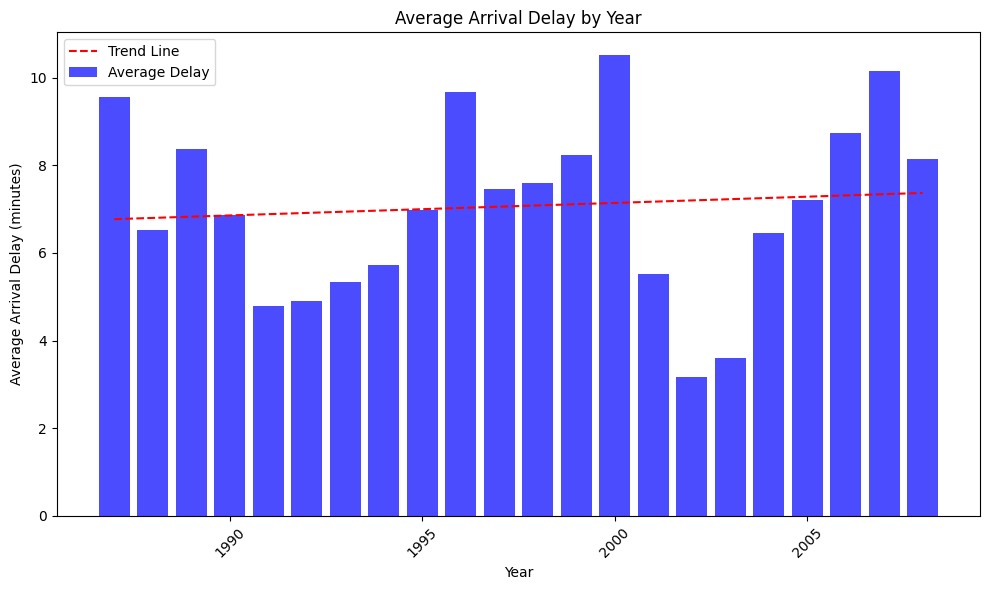

In [25]:

import matplotlib.pyplot as plt
import numpy as np
x = ans["year"]
y = ans["avgarrdelay"]

plt.figure(figsize=(10, 6))
plt.bar(x, y, color="blue", alpha=0.7, label="Average Delay")

x = ans["year"].to_numpy(dtype=float)
y = ans["avgarrdelay"].to_numpy(dtype=float)

# Drop any rows where x or y is NaN or infinite
mask = np.isfinite(x) & np.isfinite(y)
x = x[mask]
y = y[mask]

# add a trend line using numpy.polyfit
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), color="red", linestyle="--", label="Trend Line")

plt.title("Average Arrival Delay by Year")
plt.xlabel("Year")
plt.ylabel("Average Arrival Delay (minutes)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
@perf_timer
def give_answer_65(df):
    """Try to find a correlation between arrival and departure delays for flights exiting the same airport"""
    joined_df = df.alias("a").join(
        df.alias("b"),
        col("a.dest") == col("b.origin"),
        "inner"
    ).select(
        col("a.origin").alias("origin_airport"),
        col("a.dest").alias("connecting_airport"),
        col("b.dest").alias("final_airport"),
        col("a.arrdelay").alias("arrival_delay"),
        col("b.depdelay").alias("departure_delay")
    )

    # correlation
    correlation = joined_df.stat.corr("arrival_delay", "departure_delay")
    print(f"Correlation between arrival and departure delays: {correlation:.4f}")

In [29]:
import math

@perf_timer
def give_answer_65_rdd(rdd: RDD) -> None:
    """
    Compute and print Pearson correlation between arrival delays of incoming flights
    and departure delays of outgoing flights at the same connecting airport.
    Uses the RDD API end-to-end.
    """
    clean = rdd.filter(lambda row: row.origin is not None \
                             and row.dest is not None \
                             and row.arrdelay is not None \
                             and row.depdelay is not None)

    arrivals = clean.map(lambda row: (row.dest, row.arrdelay))
    departures = clean.map(lambda row: (row.origin, row.depdelay))
    joined = arrivals.join(departures)
    stats = (
        joined
        .map(lambda kv: (kv[1][0], kv[1][1], kv[1][0] * kv[1][1], kv[1][0]**2, kv[1][1]**2, 1))
        .reduce(lambda a, b: (
            a[0] + b[0],
            a[1] + b[1],
            a[2] + b[2],
            a[3] + b[3],
            a[4] + b[4],
            a[5] + b[5]
        ))
    )

    sum_x, sum_y, sum_xy, sum_x2, sum_y2, n = stats
    numerator = n * sum_xy - sum_x * sum_y
    denom_x = n * sum_x2 - sum_x * sum_x
    denom_y = n * sum_y2 - sum_y * sum_y
    if denom_x <= 0 or denom_y <= 0:
        print("Insufficient variance to compute correlation.")
        return
    correlation = numerator / math.sqrt(denom_x * denom_y)

    print(f"Correlation between arrival and departure delays: {correlation:.4f}")


In [8]:
spark.catalog.clearCache()


In [9]:
give_answer_65(small_df)

25/05/25 22:40:20 WARN MemoryStore: Not enough space to cache rdd_8_0 in memory! (computed 324.3 MiB so far)
25/05/25 22:40:21 WARN MemoryStore: Not enough space to cache rdd_8_0 in memory! (computed 324.3 MiB so far)


Correlation between arrival and departure delays: 0.0027
Function 'give_answer_65' took 18.43617 seconds to execute.


In [10]:
give_answer_65(medium_df)


25/05/25 22:42:13 WARN MemoryStore: Not enough space to cache rdd_8_0 in memory! (computed 324.3 MiB so far)
25/05/25 22:42:13 WARN MemoryStore: Not enough space to cache rdd_8_0 in memory! (computed 40.0 MiB so far)


Correlation between arrival and departure delays: 0.0020
Function 'give_answer_65' took 240.90467 seconds to execute.
Human-readable time: 4.0mins 0.9046686829969985secs


In [30]:
give_answer_65_rdd(small_rdd)


25/05/25 23:22:51 WARN MemoryStore: Not enough space to cache rdd_17_0 in memory! (computed 324.3 MiB so far)
25/05/25 23:22:51 WARN MemoryStore: Not enough space to cache rdd_17_0 in memory! (computed 40.0 MiB so far)


Correlation between arrival and departure delays: 0.0029
Function 'give_answer_65_rdd' took 64.28561 seconds to execute.
Human-readable time: 1.0mins 4.2856121420009secs
